In [4]:
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import pandas as pd

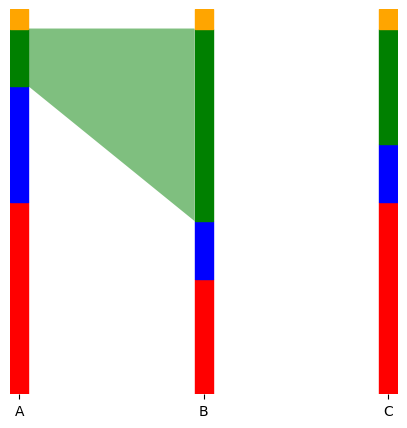

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.xaxis.set_major_locator(FixedLocator([0, 1, 2]))
ax.set_xlim([0 - 0.05, 2 + 0.05])
ax.set_xticklabels(["A", "B", "C"])

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.set_yticks([])

sizes = [[0.5, 0.3, 0.15, 0.05], [0.3, 0.15, 0.5, 0.05], [0.5, 0.15, 0.3, 0.05]]
colors = ["red", "blue", "green", "orange"]
for index, size in enumerate(sizes):
    for a_index, a_size in enumerate(size):
        rect = Rectangle(
            xy=(index - 0.05, sum(size[:a_index])), width=0.1, height=a_size, color=colors[a_index], zorder=1
        )
        ax.add_patch(rect)


poly = PathPatch(
    Path(
        vertices=[
            (0.05, 0.8),
            (0.95, 0.45),
            (0.95, 0.95),
            (0.05, 0.95),
        ],
        codes=[Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO],
        closed=True,
    ),
    color="green",
    zorder=0,
    alpha=0.5,
    lw=0,
)
ax.add_patch(poly)